# Pose Bowl: Object Detection

<a id="import-libraries"></a>

# 📚 | Import Libraries 

In [12]:
# File handling
import sys
sys.path.append('/Users/jsh/code/drivendata/spacecrafts/')
from pathlib import Path
from PIL import Image

# Pre-processing and visualization
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Modelling
import torch
import torchvision
import torch.nn as nn
from functools import partial
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms import transforms, v2
from torchvision.transforms.functional import to_pil_image
import pytorch_lightning as L
from pytorch_lightning.tuner import Tuner
from pytorch_lightning.callbacks import ModelSummary
from torchvision.models.detection.retinanet import RetinaNetHead, RetinaNetClassificationHead
from torchvision.models.detection.ssd import SSDClassificationHead
# Project specific
from scripts.score import jaccard_index
from submission_src.spacecraft_datamodule import SpacecraftDataset, SpacecraftDataModule, collate_fn
from submission_src.spacecraft_model import SpacecraftModel

<a id="configuration"></a>
# ⚙️ | Configuration

In [2]:
PROJ_DIRECTORY = Path.cwd().parent
DATA_DIRECTORY = PROJ_DIRECTORY / "data"
DEV_DIRECTORY = PROJ_DIRECTORY / "data_dev"
IMAGES_DIRECTORY = DEV_DIRECTORY / "images"
IMAGE_SIZE = (1280, 1024)
IMAGE_RESIZE_SCALE = (1/8)
IMAGE_RESIZED = (int(IMAGE_SIZE[0]*IMAGE_RESIZE_SCALE), int(IMAGE_SIZE[1]*IMAGE_RESIZE_SCALE))

<a id="datasets"></a>
# 🍚 | Datasets

In [3]:
train_meta = pd.read_csv(DEV_DIRECTORY / "train_metadata.csv", index_col="image_id")
train_labels = pd.read_csv(DEV_DIRECTORY / "train_labels.csv", index_col="image_id")
train_meta.shape, train_labels.shape

((25801, 2), (25801, 4))

In [4]:
train_labels.head()

,xmin,ymin,xmax,ymax
image_id,,,,
0001954c9f4a58f7ac05358b3cda8d20,0,277,345,709
00054819240f9d46378288b215dbcd3a,753,602,932,725
000dbf763348037b46558bbcb6a032ac,160,434,203,481
000e79208bebd8e84ce6c22fd8612a0d,70,534,211,586
000f13aff94499d03e3997afc55b0aa0,103,0,312,193


In [5]:
train_meta.head()

,spacecraft_id,background_id
image_id,,
0001954c9f4a58f7ac05358b3cda8d20,24,247
00054819240f9d46378288b215dbcd3a,14,10
000dbf763348037b46558bbcb6a032ac,19,17
000e79208bebd8e84ce6c22fd8612a0d,14,15
000f13aff94499d03e3997afc55b0aa0,28,15


In [6]:
# Examine an example image
example_img_idx = '000e79208bebd8e84ce6c22fd8612a0d'
example_img_path = Path(IMAGES_DIRECTORY, example_img_idx + '.png')
example_img = Image.open(str(example_img_path))
print('Original image', example_img.format, example_img.size, example_img.mode)

example_img = example_img.resize((int(example_img.size[0]*0.5), int(example_img.size[1]*0.5)), resample=Image.Resampling.LANCZOS)
transform = transforms.Compose([
    transforms.ToTensor(),
])

example_img = transform(example_img)

if example_img.min() >= 0 and example_img.max() <= 1:
    print("Image pixel values are in the range [0, 1].")
else:
    print("Image pixel values are not in the range [0, 1].")

print('Transformed image', example_img.shape)

Original image PNG (1280, 1024) RGB
Image pixel values are in the range [0, 1].
Transformed image torch.Size([3, 512, 640])


<a id="model"></a>
# 🤖 | Model

In [13]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection._utils import retrieve_out_channels

def get_faster_rcnn():
    # Download base model
    weights = torchvision.models.detection.FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights=weights)

    # Adjust the model for spacecraft recognition task.
    num_classes = 2 # 2 classes are spacecraft or background
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace pre-trained head with new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.train()
    return model

def get_retina_net():
    
    # Download base model
    weights = torchvision.models.detection.RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT
    model = torchvision.models.detection.retinanet_resnet50_fpn_v2(weights=weights,)

    num_classes = 2 # 2 classes are spacecraft or background

    # Replace head for Spacecraft detection task
    model.head.classification_head = RetinaNetClassificationHead(in_channels=256,
                                                                num_anchors=9,
                                                                num_classes=num_classes,
                                                                norm_layer=partial(nn.GroupNorm, 32))
    model.train()
    return model

def get_ssd():  
    # Download base model
    weights = torchvision.models.detection.SSD300_VGG16_Weights.DEFAULT
    model = torchvision.models.detection.ssd300_vgg16(weights=weights)

    num_classes = 2 # 2 classes are spacecraft or background
    num_anchors = model.anchor_generator.num_anchors_per_location()
    in_channels = retrieve_out_channels(model.backbone, (300,300))

    # Replace head for Spacecraft detection task
    model.head.classification_head = SSDClassificationHead(in_channels=in_channels, num_anchors=num_anchors, num_classes=num_classes)

    model.train()
    return model

def get_yolo():
    pass

In [179]:
model = get_ssd()

In [180]:
weights = torchvision.models.detection.SSD300_VGG16_Weights.DEFAULT
preprocess = weights.transforms()
img = read_image(str(example_img_path))
batch = [preprocess(img)]
model.eval()
prediction = model(batch)[0]
prediction

{'boxes': tensor([[1.6037e+02, 1.8727e+01, 1.2364e+03, 9.2001e+02],
         [0.0000e+00, 4.7330e+02, 8.5820e+02, 1.0240e+03],
         [5.4580e+02, 4.1059e+02, 1.2800e+03, 1.0240e+03],
         [2.8470e+01, 0.0000e+00, 7.8569e+02, 6.8304e+02],
         [5.8484e+02, 7.6904e+02, 1.2800e+03, 1.0240e+03],
         [8.8331e+02, 1.8886e+02, 1.2800e+03, 9.0062e+02],
         [3.0354e+02, 7.9469e+02, 1.0585e+03, 1.0240e+03],
         [0.0000e+00, 2.0949e+02, 4.9780e+02, 8.5856e+02],
         [4.5322e+02, 4.0345e+02, 7.7323e+02, 8.1836e+02],
         [0.0000e+00, 8.1581e+02, 5.6622e+02, 1.0240e+03],
         [3.2318e+02, 9.8602e+01, 6.2769e+02, 6.2665e+02],
         [5.9596e+02, 3.7100e+02, 9.1256e+02, 8.4198e+02],
         [3.3685e+02, 3.9789e+02, 6.3692e+02, 8.0272e+02],
         [4.5413e+02, 3.1103e+00, 8.3118e+02, 3.7578e+02],
         [5.3416e+02, 0.0000e+00, 1.2238e+03, 1.5710e+02],
         [7.2447e+02, 3.4629e+02, 1.0551e+03, 8.4935e+02],
         [4.5679e+02, 1.0474e+02, 7.7544e+02, 6

In [14]:
dataset = SpacecraftDataset(train_labels, train_meta, imgs_dir=IMAGES_DIRECTORY, transforms=transform, resize=None)
dm = SpacecraftDataModule(dataset=dataset, batch_size=2)

In [15]:
retinanet = get_retina_net()
retinanet = SpacecraftModel(retinanet)

# test the Lightning module
trainer = L.Trainer(max_epochs=2, log_every_n_steps=2, accelerator='cpu',
                    limit_train_batches=2,
                    limit_val_batches=2,)
trainer.fit(model=retinanet, datamodule=dm,)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jsh/.local/share/virtualenvs/spacecrafts-01zDKSDz-python/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name  | Type      | Params | In sizes         | Out sizes
-------------------------------------------------------------------
0 | model | RetinaNet | 36.4 M | [1, 3, 512, 640] | ['?']    
-------------------------------------------------------------------
36.1 M    Trainable params
225 K     Non-trainable params
36.4 M    Total params
145.411   Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/jsh/.local/share/virtualenvs/spacecrafts-01zDKSDz-python/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:01<00:01,  0.67it/s]

/Users/jsh/.local/share/virtualenvs/spacecrafts-01zDKSDz-python/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


/Users/jsh/.local/share/virtualenvs/spacecrafts-01zDKSDz-python/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 1: 100%|██████████| 2/2 [00:10<00:00,  0.19it/s, v_num=8, train_loss_step=1.380, valid_loss=1.400, train_loss_epoch=1.410]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 2/2 [00:11<00:00,  0.18it/s, v_num=8, train_loss_step=1.380, valid_loss=1.400, train_loss_epoch=1.410]


In [16]:
ssd = get_ssd()
ssd = SpacecraftModel(ssd)

# test the Lightning module
trainer = L.Trainer(max_epochs=2, log_every_n_steps=2, accelerator='cpu',
                    limit_train_batches=2,
                    limit_val_batches=2,)
trainer.fit(model=ssd, datamodule=dm,)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jsh/.local/share/virtualenvs/spacecrafts-01zDKSDz-python/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name  | Type | Params | In sizes         | Out sizes
--------------------------------------------------------------
0 | model | SSD  | 23.7 M | [1, 3, 512, 640] | ['?']    
--------------------------------------------------------------
23.7 M    Trainable params
38.7 K    Non-trainable params
23.7 M    Total params
94.984    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/jsh/.local/share/virtualenvs/spacecrafts-01zDKSDz-python/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Users/jsh/.local/share/virtualenvs/spacecrafts-01zDKSDz-python/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 1: 100%|██████████| 2/2 [00:02<00:00,  0.81it/s, v_num=9, train_loss_step=8.260, valid_loss=16.50, train_loss_epoch=8.510]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 2/2 [00:02<00:00,  0.76it/s, v_num=9, train_loss_step=8.260, valid_loss=16.50, train_loss_epoch=8.510]


In [182]:
batch = next(iter(dm.train_dataloader()))


In [98]:
model.model.train()
images, targets = batch
model.model(images, targets)

{'classification': tensor(1.1311, grad_fn=<DivBackward0>),
 'bbox_regression': tensor(0.6110, grad_fn=<DivBackward0>)}

<a id="training"></a>
# 🚂 | Training

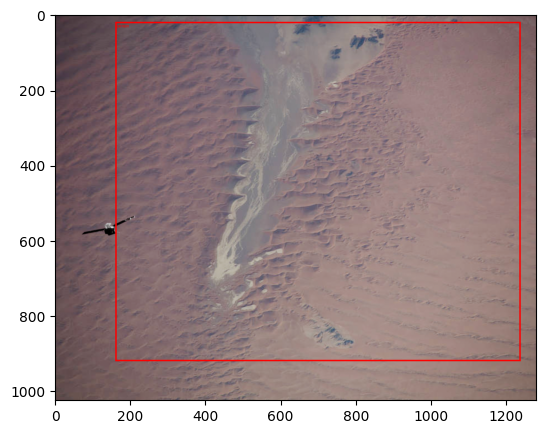

In [181]:
labels = [weights.meta["categories"][i] for i in prediction["labels"]]
best_bbox = prediction["boxes"][0].reshape(1,4)
label = [labels[0]]
box = draw_bounding_boxes(img, boxes=best_bbox,
                          labels=label,
                          colors="red",
                          width=4, font_size=30)
# im = to_pil_image(box.detach())
# im.show()
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot()
box = np.transpose(box, (1,2,0))
ax.imshow(box)

# 🩼 | Helper Functions

In [18]:
def get_bbox(image_id, labels):
    """Get bbox coordinates as list from dataframe for given image id."""
    return labels.loc[image_id].loc[["xmin", "ymin", "xmax", "ymax"]].values

def display_image_from_file(image_id, images_dir=IMAGES_DIRECTORY, show_bbox=False, labels=None, pred_bbox=None):
    """Display image given image ID. Annotate with bounding box if `show_bbox` is True."""
    img = cv2.imread(str(images_dir / f"{image_id}.png"))
    fig, ax = plt.subplots()
    # cv2 reads images as BGR order; we should flip them to RGB for matplotlib
    # ref: https://stackoverflow.com/questions/54959387/rgb-image-display-in-matplotlib-plt-imshow-returns-a-blue-image
    ax.imshow(np.flip(img, axis=-1))

    if show_bbox:
        xmin, ymin, xmax, ymax = get_bbox(image_id, labels)
        patch = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='white', linewidth=1)
        ax.add_patch(patch)

    if pred_bbox is not None:
        xmin, ymin, xmax, ymax = pred_bbox
        patch = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='blue', linewidth=1)
        ax.add_patch(patch)       

In [19]:
def centered_box(img_size=IMAGE_RESIZED, scale=0.1):
    """
    Return coordinates for a centered bounding box on the image, defaulting to 10% of the image's height and width.
    """
    # Get image dimensions
    width, height = img_size
    # Calculate the center of the image
    center_x, center_y = width // 2, height // 2
    # Calculate 10% of the image's height and width for the bounding box
    box_width, box_height = width * scale, height * scale
    # Calculate top-left corner of the bounding box
    x1 = center_x - box_width // 2
    y1 = center_y - box_height // 2
    # Calculate bottom-right corner of the bounding box
    x2 = center_x + box_width // 2
    y2 = center_y + box_height // 2

    return [x1, y1, x2, y2]

def get_predicted_bboxes(preds):
    """
    Extract the top bounding box prediction from the predications. If no prediction then use a centered box.
    """
    preds = [{k: v.to('cpu') if isinstance(v, torch.Tensor) else v for k, v in p.items()} for p in preds]
    bbox_list = []
    
    for pred in preds:
        if len(pred['boxes']) > 0:
            bbox_list.append(pred['boxes'][0])
        else:
            bbox_list.append(torch.Tensor(centered_box()))
    return torch.stack(bbox_list)

def get_target_bboxes(targets):
    """
    Extract the bounding boxes from the 'targets' portion of a dataloader batch.
    """
    targets = [{k: v.to('cpu') if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
    return torch.stack([target['boxes'] for target in targets])


## 📋 | Result

In [23]:
ssd.eval()
dm.setup()
for i, data in enumerate(dm.val_dataloader()):
    if i == 1:
        images, targets = data
        with torch.no_grad():
            predictions = ssd(images)
        break

In [20]:
def show_image(img_idx=None, img=None, pred_bbox=None, target_bbox=None, ax=None):
    img = np.transpose(img, (1,2,0))
    ax.imshow(img)

    if target_bbox is not None:
        xmin, ymin, xmax, ymax = target_bbox
        height = ymax - ymin
        width = xmax - xmin
        patch = Rectangle((xmin, ymin), width, height, fill=False, edgecolor='white', linewidth=2)
        ax.add_patch(patch)
        # ax.text(xmin + width - 63, ymin + height - 30, 'Target', color='r', ha='center', va='center', fontsize=8, bbox=dict(facecolor='white', edgecolor='white', alpha=0.5))

    if pred_bbox is not None:
        xmin, ymin, xmax, ymax = pred_bbox
        height = ymax - ymin
        width = xmax - xmin
        patch = Rectangle((xmin, ymin), width, height, fill=False, edgecolor='blue', linewidth=2)
        ax.add_patch(patch)
        # ax.text(xmin + width - 55, ymin + height - 30, 'Pred', color='white', ha='center', va='center', fontsize=8, bbox=dict(facecolor='blue', edgecolor='blue', alpha=0.5))
    
    if (pred_bbox is not None) and (target_bbox is not None):
       jac = jaccard_index(pred_bbox.reshape(1,4), target_bbox.reshape(1,4))
    else:
       jac = 'n/a' 

    title = f'Image: {img_idx}\nJaccard: {jac[0]:.4f}'
    ax.set_title(title)
    # ax.set_xticks([])
    # ax.set_yticks([])

In [21]:
def display_images(images, targets, preds, cols=2, device='cpu'):
    images = list(image.to(device) for image in images)
    
    rows = (len(images) + cols - 1) // 2
    fig = plt.figure(figsize=(15, 5*rows))
    predicted_bboxes = get_predicted_bboxes(preds).detach().cpu().numpy()
    target_bboxes = get_target_bboxes(targets).cpu().numpy().squeeze()
    
    for idx, target in enumerate(targets):
        img_idx = target['image_id']
        target_bbox = target_bboxes[idx]
        pred_bbox = predicted_bboxes[idx]
        img = images[idx]
        ax = fig.add_subplot(rows, cols, idx + 1)
        show_image(img_idx, img, pred_bbox, target_bbox, ax)

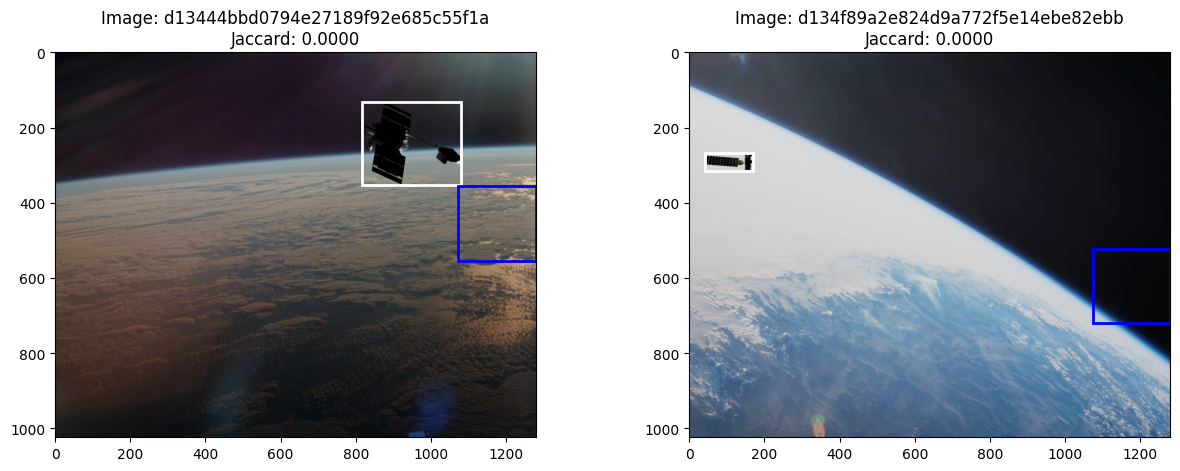

In [24]:
display_images(images[:2], targets[:2], predictions[:2], cols=2)

In [20]:
ckpt_path = '/Users/jsh/code/drivendata/spacecrafts/notebooks/lightning_logs/version_0/checkpoints/epoch=5-step=1974.ckpt'

In [21]:
checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))

In [22]:
state_dict = checkpoint['state_dict']

In [23]:
frcnn.load_state_dict(state_dict)

<All keys matched successfully>

In [39]:
predictions[2]

{'boxes': tensor([[0.0000e+00, 3.4498e+02, 1.2800e+03, 7.0841e+02],
         [0.0000e+00, 2.4993e+02, 1.2800e+03, 5.4031e+02],
         [0.0000e+00, 1.7935e+01, 1.2800e+03, 6.4607e+02],
         [0.0000e+00, 8.0903e+02, 1.2800e+03, 8.2877e+02],
         [0.0000e+00, 7.9698e+02, 1.2800e+03, 8.1863e+02],
         [0.0000e+00, 7.7780e+02, 1.2800e+03, 8.0309e+02],
         [0.0000e+00, 7.1126e+02, 1.2800e+03, 7.4871e+02],
         [0.0000e+00, 9.4976e+02, 1.2800e+03, 1.0240e+03],
         [0.0000e+00, 7.5976e+02, 1.2800e+03, 7.8397e+02],
         [0.0000e+00, 5.8346e+02, 1.2800e+03, 1.0240e+03],
         [0.0000e+00, 5.3292e+02, 1.2800e+03, 6.3474e+02],
         [0.0000e+00, 1.3112e+02, 1.2800e+03, 4.1801e+02],
         [0.0000e+00, 6.6121e+02, 1.2800e+03, 6.9453e+02],
         [0.0000e+00, 1.0077e+03, 1.2800e+03, 1.0240e+03],
         [2.7505e+02, 1.5574e+02, 6.9521e+02, 9.2170e+02],
         [4.8267e+02, 1.5466e+02, 8.9909e+02, 9.2017e+02],
         [0.0000e+00, 5.0675e+02, 1.2800e+03, 7